<a href="https://colab.research.google.com/github/YeomSuWoong/SOCAR-AI-BOOT-CAMP/blob/main/Assignment_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
root = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'Colab Notebooks', 'data')
root

'/content/drive/MyDrive/Colab Notebooks/data'

In [ ]:
mnist_train = datasets.MNIST(
    root = root,
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
mnist_test = datasets.MNIST(
    root = root,
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

In [ ]:
fmnist_train = datasets.FashionMNIST(
    root = root,
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
fmnist_test = datasets.FashionMNIST(
    root = root,
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

In [ ]:
class mnist_dataset(Dataset):
  def __init__(self, data, targets, transform=None, target_transform=None):
    super().__init__()

    self.data = data
    self.targets = targets
    self.transform = transform
    self.target_transform = target_transform
    pass

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    x, y = self.data[idx], self.targets[idx]

    if self.transform:
      x = self.transform(x)
    if self.target_transform:
      y = self.target_transform(y)

    return x, y

In [ ]:
def split_train_valid(dataset, valid_ratio=0.1):
  n_valid = int(len(dataset) * valid_ratio)
  
  train_data = dataset.data[:-n_valid].numpy()
  valid_data = dataset.data[-n_valid:].numpy()
  train_targets = dataset.targets[:-n_valid]
  valid_targets = dataset.targets[-n_valid:]

  train = mnist_dataset(data=train_data, targets=train_targets,
                        transform=dataset.transform,
                        target_transform=dataset.target_transform)
  valid = mnist_dataset(data=valid_data, targets=valid_targets,
                        transform=dataset.transform,
                        target_transform=dataset.target_transform)

  return train, valid

In [ ]:
mnist_train, mnist_valid = split_train_valid(dataset=mnist_train)
fmnist_train, fmnist_valid = split_train_valid(dataset=fmnist_train)

In [ ]:
mnists = {}
mnists["mnist"] = {"train": mnist_train, "valid": mnist_valid, "test": mnist_test}
mnists["fmnist"] = {"train": fmnist_train, "valid": fmnist_valid, "test": fmnist_test}

for k in mnists.keys():
  print(f"Length of {k}: train - {len(mnists[k]['train'])}, valid - {len(mnists[k]['valid'])}, test - {len(mnists[k]['test'])}.")

Length of mnist: train - 54000, valid - 6000, test - 10000.
Length of fmnist: train - 54000, valid - 6000, test - 10000.


In [ ]:
loaders = {}
for k in mnists.keys():
  loaders[k] = {s: DataLoader(dataset=mnists[k][s], batch_size=512 if k == "emnist" else 64, shuffle= s == "train", drop_last=True) for s in ["train", "valid", "test"]}

In [ ]:
class LionMNISTDropoutBNClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 392),
        nn.BatchNorm1d(392),
        nn.Dropout(p=0.4),
        nn.ReLU(),
        nn.Linear(392, 196),
        nn.BatchNorm1d(196),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.Linear(196, 98),
        nn.BatchNorm1d(98),
        nn.Dropout(p=0.1),
        nn.ReLU(),
        nn.Linear(98, n_class),
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
class Trainer(nn.Module):
  def __init__(self, model_class, loaders, n_class=10, opt="sgd", lr=0.001, has_scheduler=False, device="cpu"):
    super().__init__()

    self.model = model_class(n_class=n_class)
    self.loss = nn.CrossEntropyLoss()
    
    self.train_loader = loaders["train"]
    self.valid_loader = loaders["valid"]
    self.test_loader = loaders["test"]

    self._get_optimizer(opt=opt.lower(), lr=lr)
    self.has_scheduler = has_scheduler
    if self.has_scheduler:
      self._get_scheduler()

    self.device = device
    pass

  def _get_optimizer(self, opt, lr=0.001):
    if opt == "sgd":
      self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
    elif opt == "adam":
      self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
    elif opt == 'rmsprop':
      self.optimizer = torch.optim.RMSprop(params=self.model.parameters(), lr=lr)
    elif opt == 'adagrad':
      self.optimizer = torch.optim.Adagrad(params=self.model.parameters(), lr=lr)
    elif opt == 'momentum':
      self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr, momentum=0.95)
    elif opt == 'nadam':
      self.optimizer = torch.optim.NAdam(params=self.model.parameters(), lr=lr)
    elif opt == 'radam':
      self.optimizer = torch.optim.RAdam(params=self.model.parameters(), lr=lr)
    elif opt == 'adamw':
      self.optimizer = torch.optim.AdamW(params=self.model.parameters(), lr=lr)
    elif opt == 'sparseadam':
      self.optimizer = torch.optim.SparseAdam(params=self.model.parameters(), lr=lr)
    elif opt == 'adamax':
      self.optimizer = torch.optim.Adamax(params=self.model.parameters(), lr=lr)
    else:
      raise ValueError(f"optimizer {opt} is not supproted")

  def _get_scheduler(self):
    self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)

  def train(self, max_epochs=10):
    print("===== Train Start =====")
    history = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}
    for e in range(max_epochs):
      train_loss, train_acc = self._train_epoch()
      valid_loss, valid_acc = self._valid_epoch()

      history["train_loss"].append(train_loss)
      history["train_acc"].append(train_acc)
      history["valid_loss"].append(valid_loss)
      history["valid_acc"].append(valid_acc)

      if self.has_scheduler:
        self.scheduler.step()

      if e % 5 == 0:
        print(f"Epoch: {e}, train loss: {train_loss:>6f}, train acc: {train_acc:>3f}, valid loss: {valid_loss:>6f}, valid acc: {valid_acc:>3f}")

    self.plot_history(history)

  def _train_epoch(self):
    epoch_loss, epoch_acc = 0, 0
    self.model.train()
    for (x, y) in self.train_loader:
      x = x.to(self.device)
      y = y.to(self.device)

      y_hat = self.model(x)
      loss = self.loss(y_hat, y)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      epoch_loss += loss.to("cpu").item()
      epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    epoch_loss /= len(self.train_loader)
    epoch_acc /= len(self.train_loader)

    return epoch_loss, epoch_acc
  
  def _valid_epoch(self):
    epoch_loss, epoch_acc = 0, 0
    self.model.eval()
    with torch.no_grad():
      for (x, y) in self.valid_loader:
        x = x.to(self.device)
        y = y.to(self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        epoch_loss += loss.to("cpu").item()
        epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    epoch_loss /= len(self.valid_loader)
    epoch_acc /= len(self.valid_loader)

    return epoch_loss, epoch_acc

  def plot_history(self, history):
    fig = plt.figure(figsize=(20, 10))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history["train_loss"], color="red", label="train loss")
    ax.plot(history["valid_loss"], color="blue", label="valid loss")
    ax.set_title("Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history["train_acc"], color="red", label="train acc")
    ax.plot(history["valid_acc"], color="blue", label="valid acc")
    ax.set_title("Acc")
    ax.legend()

    fig.show()

  def test(self):
    print("===== Test Start =====")
    epoch_loss, epoch_acc = 0, 0
    self.model.eval()
    with torch.no_grad():
      for (x, y) in self.test_loader:
        x = x.to(self.device)
        y = y.to(self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        epoch_loss += loss.to("cpu").item()
        epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    epoch_loss /= len(self.test_loader)
    epoch_acc /= len(self.test_loader)

    print(f"Test loss: {epoch_loss:>6f}, Test acc: {epoch_acc:>3f}")

===== Train Start =====
Epoch: 0, train loss: 0.546069, train acc: 0.807421, valid loss: 0.395272, valid acc: 0.855007
Epoch: 5, train loss: 0.333116, train acc: 0.877817, valid loss: 0.332255, valid acc: 0.875840
Epoch: 10, train loss: 0.288560, train acc: 0.893201, valid loss: 0.293783, valid acc: 0.891801
Epoch: 15, train loss: 0.260290, train acc: 0.902821, valid loss: 0.288647, valid acc: 0.894153
Epoch: 20, train loss: 0.236385, train acc: 0.911477, valid loss: 0.287135, valid acc: 0.896337
Epoch: 25, train loss: 0.221642, train acc: 0.916908, valid loss: 0.290164, valid acc: 0.898185
===== Test Start =====
Test loss: 0.299638, Test acc: 0.894231


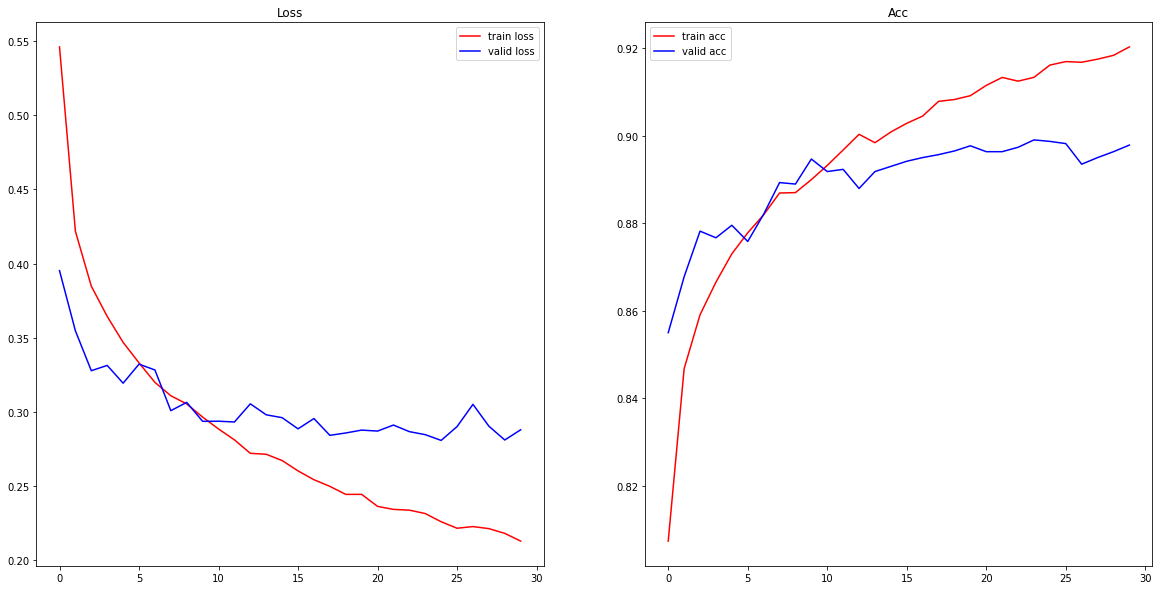

In [ ]:
trainer = Trainer(model_class=LionMNISTDropoutBNClassifier, loaders=loaders["fmnist"], n_class=10, opt="adamw", lr=0.0018, device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()

Adjusting learning rate of group 0 to 1.0000e-03.
===== Train Start =====
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 0, train loss: 0.328246, train acc: 0.908085, valid loss: 0.094766, valid acc: 0.970262
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Epoch: 5, train loss: 0.075862, train acc: 0.975923, valid loss: 0.051973, valid acc: 0.985551
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 2.5000e-04.
Adjusting learning rate of group 0 to 2.5000e-04.
Epoch: 10, train loss: 0.047052, train acc: 0.984968, valid loss: 0.047866, valid acc: 0.987567
Adjusting learning rate of group 0 to 2.5000e-04.
Adjusting learning rate of group 0 to 2.

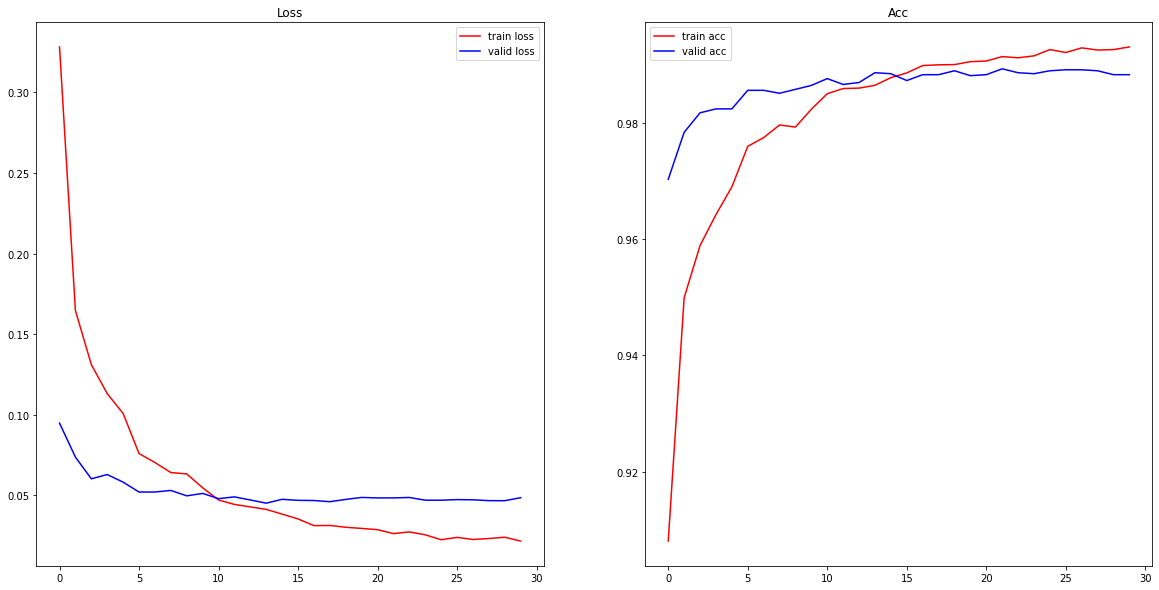

In [ ]:
trainer = Trainer(model_class=LionMNISTDropoutBNClassifier, loaders=loaders["mnist"], n_class=10, opt="adamw", lr=0.001, has_scheduler=True, device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()